**Install Dependencies**

In [1]:
pip install lazypredict

**Import libraries**

In [2]:
import json
import zipfile
import numpy as np
import pandas as pd


import os
import time

import missingno

from sklearn.preprocessing import StandardScaler


from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


import plotly.graph_objects as go

from ipywidgets import widgets
from google.colab import files
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
os.getcwd()

'/content'

In [4]:
os.listdir()

['.config', 'benign', 'malicious', '.DS_Store', 'features.zip', 'sample_data']

In [5]:
f_name = 'features.zip'
print('File size', os.path.getsize(f_name) / 1024 / 1024, 'MB')

File size 10.367868423461914 MB


In [6]:
# To unzip the archive 'features.zip' in the current directory

start = time.perf_counter()   # Get current (relative) time in program

with zipfile.ZipFile(f_name, 'r') as fd:
    fd.extractall('.')

end = time.perf_counter()  # Get current (relative) time in program
print('Time to unzip', f_name, ':', end - start, 'seconds')

Time to unzip features.zip : 2.6494245899993984 seconds


In [7]:
os.listdir()

['.config', 'benign', 'malicious', '.DS_Store', 'features.zip', 'sample_data']

In [8]:
def count_files(directory_path):
  '''
    Function to count the number of files in a sub-directory.
  '''
  count = 0
  flag = 0
  for path in os.listdir(directory_path):
      # check if current path is a file
      if not os.path.isfile(os.path.join(directory_path, path)):
        try:
          raise Exception('Unexpected behaviour - A directory is encountered!')
        except Exception as e:
          print(e)
          flag = 1
          break
      else:
        count += 1

  if flag == 0:
    return count

In [9]:
num_benign_files = count_files('./benign')
print(f'Number of files in sub-directory ./benign is {num_benign_files}')

Number of files in sub-directory ./benign is 5000


In [10]:
num_malicious_files = count_files('./malicious')
print(f'Number of files in sub-directory ./malicious is {num_malicious_files}')

Number of files in sub-directory ./malicious is 5000


## Functional Modules

In [11]:
def reformat_json(json_dict, filename):
  reformatted_json = {'filesize': float(json_dict['file_size']),
                      'pypdf_uris': len(json_dict['pypdf_uris']),
                      'regex_uris': len(json_dict['regex_uris']),
                      'regex_urls': len(json_dict['regex_urls']),
                      'scripts_iframe': len(json_dict['scripts']['iframe']),
                      'scripts_urls': len(json_dict['scripts']['urls']),
                  }

  # Process static_properties
  for key, value in json_dict['static_properties'].items():
    try:
      reformatted_json[f'static_properties_{key}'] = float(value)
    except ValueError as ve:
                print('Exception caught -', ve)
                print('key = ', key)
                print(filename, '\n')
                reformatted_json[f'static_properties_{key}'] = np.NaN


  # Process yara_signatures
  for signature in json_dict['yara_signatures']:
    reformatted_json[f'yara_signatures_{signature}'] = True

  return reformatted_json


In [12]:
def load_dataset(dir_path):
  # Initialize an empty list to store individual dataframes
  dfs = []

  # Iterate through each file in the folder
  for filename in os.listdir(dir_path):
      if filename.endswith(".json"):
          file_path = os.path.join(dir_path, filename)

          # Read the JSON file into a dictionary
          with open(file_path, 'r') as file:
              json_data = json.load(file)
              reformatted_json = reformat_json(json_data, filename)

              #reformatted_json['Verdict'] = verdict

          # Convert the dictionary to a DataFrame
          df = pd.json_normalize(reformatted_json)

          # Append the DataFrame to the list
          dfs.append(df)

  # Concatenate all DataFrames in the list into a single DataFrame
  final_df = pd.concat(dfs, ignore_index=True)

  return final_df

In [13]:
def generate_verdict_column(verdict, json_count):
  verdict_df = pd.DataFrame([verdict] * json_count, columns = ['Verdict'])
  return verdict_df

## Load Dataset

**Loading Benign Dataset**

In [14]:
benign_df = load_dataset('./benign')
benign_df.head()

,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,yara_signatures_Big_Numbers0,yara_signatures_multiple_filtering,yara_signatures_suspicious_launch_action,yara_signatures_JBIG2_wrong_version,yara_signatures_header_evasion,yara_signatures_MoleBoxv20,yara_signatures_possible_includes_base64_packed_functions,yara_signatures_FlateDecode_wrong_version,yara_signatures_memory_shylock,yara_signatures_maldoc_OLE_file_magic_number
0,3306210.00,0,0,49,0,0,0.00,0.00,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5956032.00,860,0,8,0,0,0.00,0.00,0.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27226.00,0,0,0,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,930711.00,0,0,14,0,0,0.00,0.00,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,220436.00,0,0,5,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
benign_df.columns

Index(['filesize', 'pypdf_uris', 'regex_uris', 'regex_urls', 'scripts_iframe',
       'scripts_urls', 'static_properties_JBIG2Decode',
       'static_properties_XML_forms', 'static_properties_acro_form',
       'static_properties_auto_action', 'static_properties_colors',
       'static_properties_cross_reference_table',
       'static_properties_embedded_files', 'static_properties_file_size',
       'static_properties_java_script', 'static_properties_js',
       'static_properties_launch_action', 'static_properties_object_end',
       'static_properties_object_start', 'static_properties_object_streams',
       'static_properties_open_action', 'static_properties_page_count',
       'static_properties_rich_media',
       'static_properties_start_cross_reference_table',
       'static_properties_stream_end', 'static_properties_stream_start',
       'static_properties_trailer_dictionary',
       'yara_signatures_without_attachments', 'yara_signatures_without_images',
       'yara_signature

In [16]:
len(benign_df.columns)

53

In [17]:
verdict_df = generate_verdict_column(False, num_benign_files)
benign_df_list = [benign_df, verdict_df]
benign_df = pd.concat(benign_df_list, axis = 1)

In [18]:
benign_df.shape

(5000, 54)

**Loading Malicious Dataset**

In [19]:
malicious_df = load_dataset('./malicious')
malicious_df.head()

Exception caught - could not convert string to float: '-'
key =  file_size
ac233897d712ffac1e1da515101ebe8c61644a688359c1f1ad98c539f4e411e1.properties.json 



,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,yara_signatures_possible_exploit,yara_signatures_with_images,yara_signatures_without_urls,yara_signatures_suspicious_launch_action,yara_signatures_suspicious_embed,yara_signatures_PDF_Embedded_Exe,yara_signatures_Big_Numbers3,yara_signatures_CRC32c_poly_Constant,yara_signatures_Cerberus,yara_signatures_xtreme_rat
0,386716.00,1,1,7,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37305.00,22,22,22,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86489.00,4,4,4,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,506198.00,25,25,32,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45516.00,22,22,22,0,0,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
malicious_df.shape

(5000, 52)

In [21]:
malicious_df['static_properties_file_size'].isna().sum()

1

In [22]:
set(benign_df.columns) - set(malicious_df.columns)

{'Verdict',
 'yara_signatures_Big_Numbers4',
 'yara_signatures_FlateDecode_wrong_version',
 'yara_signatures_IsSuspicious',
 'yara_signatures_JBIG2_wrong_version',
 'yara_signatures_MoleBoxv20',
 'yara_signatures_header_evasion',
 'yara_signatures_maldoc_OLE_file_magic_number',
 'yara_signatures_memory_shylock',
 'yara_signatures_multiple_filtering'}

In [23]:
set(malicious_df.columns) - set(benign_df.columns)

{'yara_signatures_CRC32c_poly_Constant',
 'yara_signatures_Cerberus',
 'yara_signatures_PDF_Embedded_Exe',
 'yara_signatures_RSharedStrings',
 'yara_signatures_possible_exploit',
 'yara_signatures_suspicious_creator',
 'yara_signatures_suspicious_embed',
 'yara_signatures_xtreme_rat'}

In [24]:
with open(os.path.join('./malicious', 'ac233897d712ffac1e1da515101ebe8c61644a688359c1f1ad98c539f4e411e1.properties.json'), 'r') as json_file:
  json_obj = json.load(json_file)
  json_content = json.dumps(json_obj, indent = 1)
  print(json_content)

{
 "exif_signatures": {},
 "file_size": 373494,
 "pdfid_signatures": {},
 "pypdf_uris": [
  "http://eelruxe.com/c3?utm_term=caterpillar+c18+marine+diesel+engine+manuals+online+free",
  "https://static1.squarespace.com/static/604aebe5436e397a99d53e8a/t/62c751ba5322c12119c00e9f/1657229754873/80584900780.pdf",
  "https://static1.squarespace.com/static/604aeb86718479732845b7b4/t/62c22a935afcae5eb9ad88b2/1656892051598/namujesinawesunevetas.pdf",
  "https://static1.squarespace.com/static/60aaf25e42d7b60106dc17aa/t/62bbe8865819fb64ad16dcf4/1656481926596/99992732899.pdf",
  "https://static1.squarespace.com/static/604aea6a97201213e037dc4e/t/62c84fcc9e7f3f28969bfc03/1657294796863/94287215864.pdf",
  "https://variwigegepug.weebly.com/uploads/1/3/4/3/134348450/8251570.pdf",
  "https://bekonanokovokam.weebly.com/uploads/1/4/1/6/141627960/jonoxalabisaxovuve.pdf",
  "https://static1.squarespace.com/static/60aaf27c8bac0413e6f804fa/t/62b9ee190e1caa52df555a3a/1656352281789/ferinixafudorewigovetez.pdf",


In [25]:
verdict_df = generate_verdict_column(True, num_malicious_files)
malicious_df_list = [malicious_df, verdict_df]
malicious_df = pd.concat(malicious_df_list, axis = 1)

In [26]:
malicious_df.shape

(5000, 53)

In [27]:
malicious_df.columns.values

array(['filesize', 'pypdf_uris', 'regex_uris', 'regex_urls',
       'scripts_iframe', 'scripts_urls', 'static_properties_JBIG2Decode',
       'static_properties_XML_forms', 'static_properties_acro_form',
       'static_properties_auto_action', 'static_properties_colors',
       'static_properties_cross_reference_table',
       'static_properties_embedded_files', 'static_properties_file_size',
       'static_properties_java_script', 'static_properties_js',
       'static_properties_launch_action', 'static_properties_object_end',
       'static_properties_object_start',
       'static_properties_object_streams',
       'static_properties_open_action', 'static_properties_page_count',
       'static_properties_rich_media',
       'static_properties_start_cross_reference_table',
       'static_properties_stream_end', 'static_properties_stream_start',
       'static_properties_trailer_dictionary',
       'yara_signatures_without_attachments',
       'yara_signatures_without_images', 'yara_si

**Merging Benign and Malicious Dataset into one DataFrame**

In [28]:
pdf_df = benign_df.append(malicious_df, ignore_index = True)

In [29]:
pdf_df.head()

,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,yara_signatures_maldoc_OLE_file_magic_number,Verdict,yara_signatures_suspicious_creator,yara_signatures_RSharedStrings,yara_signatures_possible_exploit,yara_signatures_suspicious_embed,yara_signatures_PDF_Embedded_Exe,yara_signatures_CRC32c_poly_Constant,yara_signatures_Cerberus,yara_signatures_xtreme_rat
0,3306210.00,0,0,49,0,0,0.00,0.00,1.00,0.00,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5956032.00,860,0,8,0,0,0.00,0.00,0.00,1.00,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27226.00,0,0,0,0,0,0.00,0.00,0.00,0.00,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,930711.00,0,0,14,0,0,0.00,0.00,1.00,0.00,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,220436.00,0,0,5,0,0,0.00,0.00,0.00,0.00,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
pdf_df.shape

(10000, 62)

In [31]:
pdf_df['Verdict'].unique()

array([False,  True])

# Feature Engineering

In [32]:
# Unique data types present in the DataFrame

unique_data_types = pdf_df.dtypes.unique()
unique_data_types

array([dtype('float64'), dtype('int64'), dtype('O'), dtype('bool')],
      dtype=object)

In [33]:
pdf_df.isna().sum()

filesize                                   0
pypdf_uris                                 0
regex_uris                                 0
regex_urls                                 0
scripts_iframe                             0
                                        ... 
yara_signatures_suspicious_embed        9999
yara_signatures_PDF_Embedded_Exe        9999
yara_signatures_CRC32c_poly_Constant    9997
yara_signatures_Cerberus                9998
yara_signatures_xtreme_rat              9999
Length: 62, dtype: int64

<Axes: >

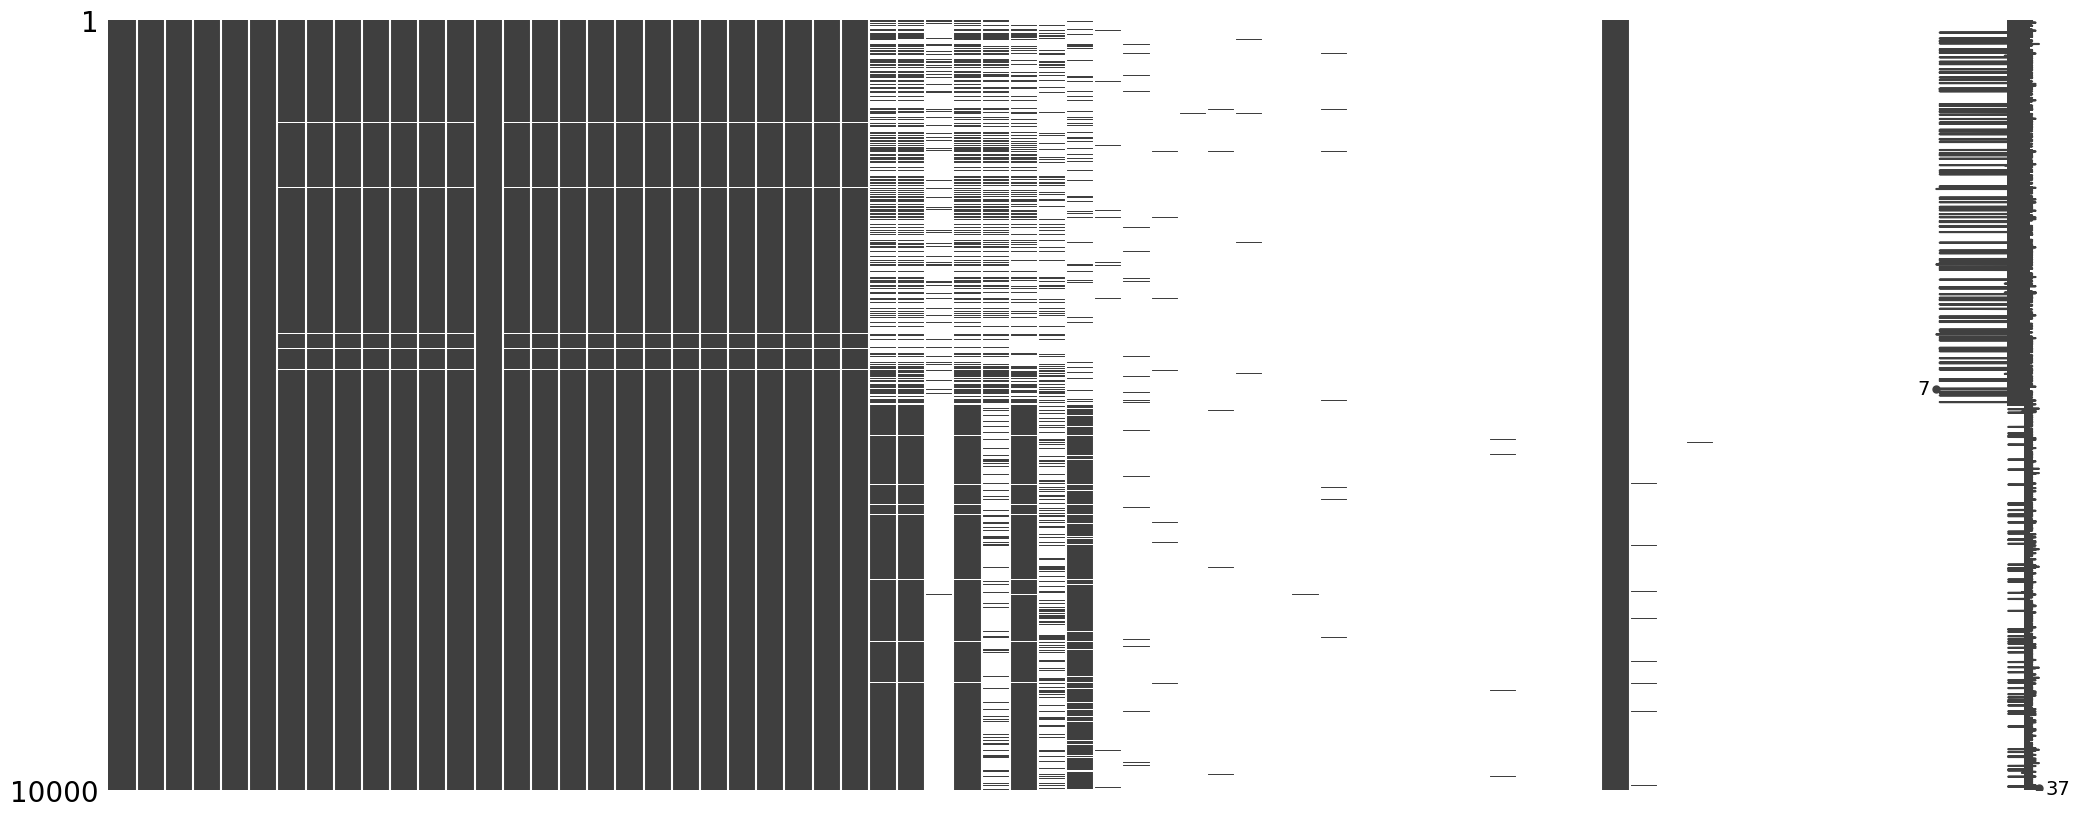

In [34]:
# Visual representation of the missing data in the dataset

missingno.matrix(pdf_df)

In [35]:
pdf_df.loc[:, pdf_df.columns.str.startswith('yara_signatures_')] = pdf_df.loc[:, pdf_df.columns.str.startswith('yara_signatures_')].fillna(False)

In [36]:
columns_with_missing = pdf_df.columns[pdf_df.isnull().any()]
pdf_df[columns_with_missing].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   static_properties_JBIG2Decode                  9883 non-null   float64
 1   static_properties_XML_forms                    9883 non-null   float64
 2   static_properties_acro_form                    9883 non-null   float64
 3   static_properties_auto_action                  9883 non-null   float64
 4   static_properties_colors                       9883 non-null   float64
 5   static_properties_cross_reference_table        9883 non-null   float64
 6   static_properties_embedded_files               9883 non-null   float64
 7   static_properties_file_size                    9983 non-null   float64
 8   static_properties_java_script                  9883 non-null   float64
 9   static_properties_js                           9883

In [37]:
pdf_df[columns_with_missing].isna().sum()

static_properties_JBIG2Decode                    117
static_properties_XML_forms                      117
static_properties_acro_form                      117
static_properties_auto_action                    117
static_properties_colors                         117
static_properties_cross_reference_table          117
static_properties_embedded_files                 117
static_properties_file_size                       17
static_properties_java_script                    117
static_properties_js                             117
static_properties_launch_action                  117
static_properties_object_end                     117
static_properties_object_start                   117
static_properties_object_streams                 117
static_properties_open_action                    117
static_properties_page_count                     117
static_properties_rich_media                     117
static_properties_start_cross_reference_table    117
static_properties_stream_end                  

<Axes: >

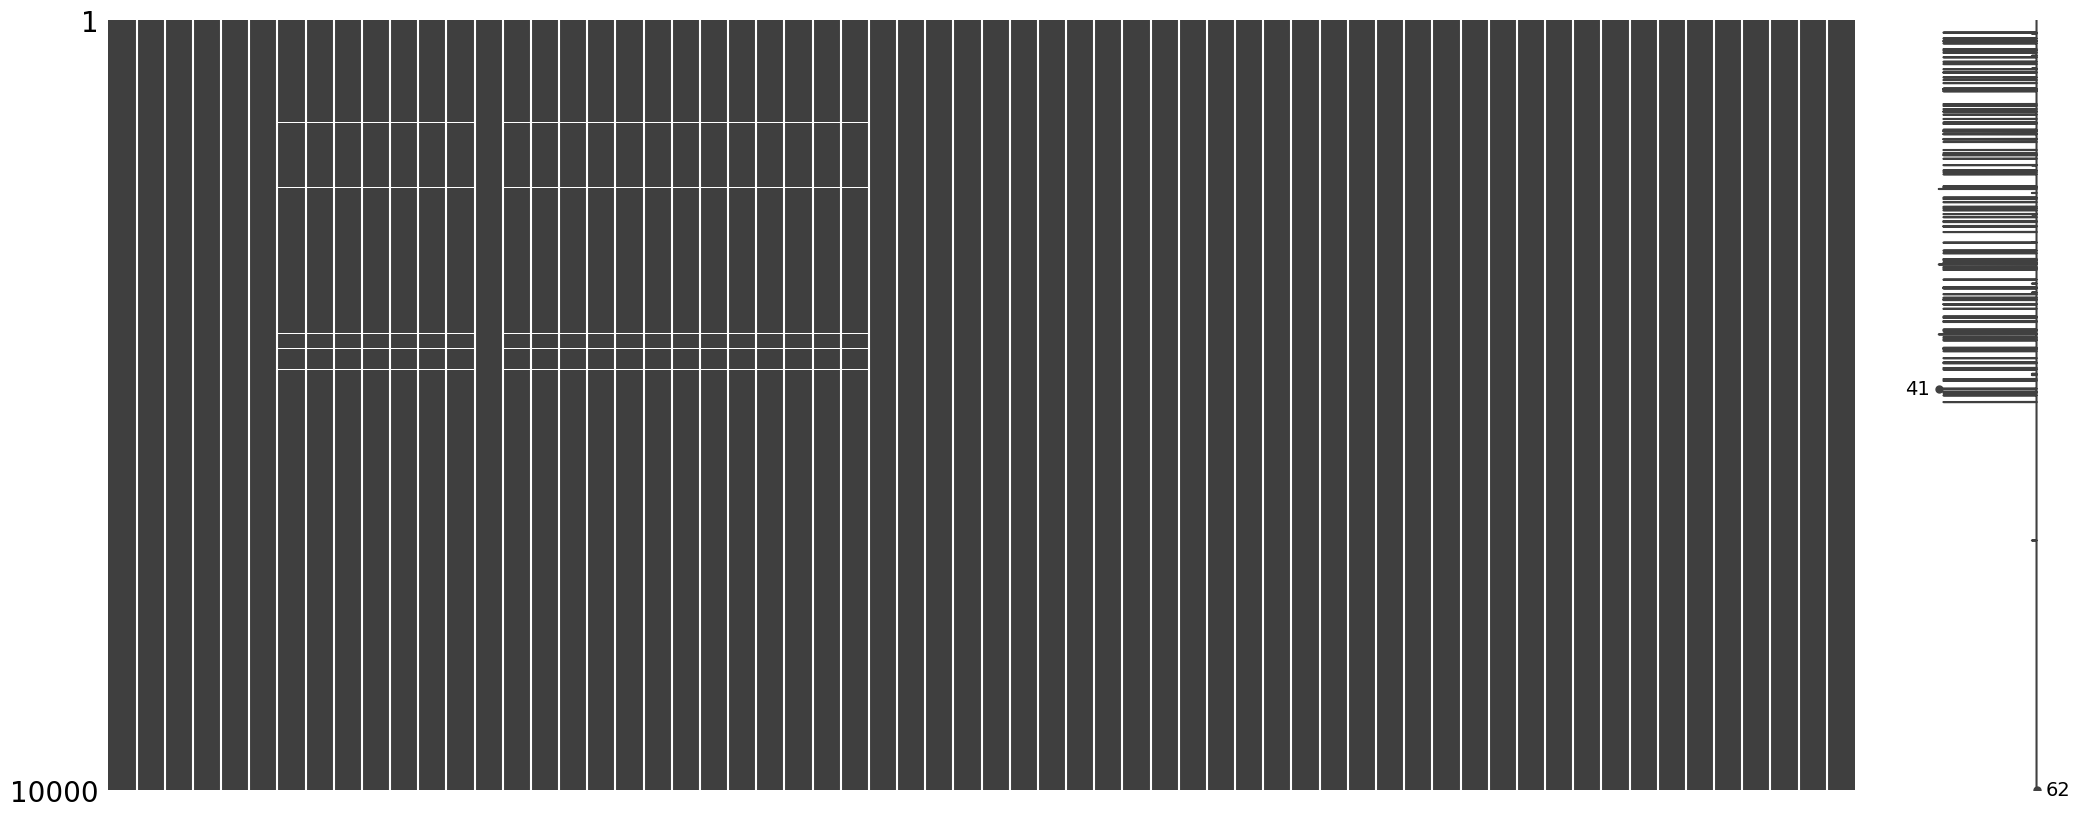

In [38]:
# Visual representation of the missing data in the dataset

missingno.matrix(pdf_df)

In [39]:
# Imputing numeric missing vakues with mean

pdf_df = pdf_df.fillna(pdf_df.median())

In [40]:
columns_with_missing = pdf_df.columns[pdf_df.isnull().any()]
pdf_df[columns_with_missing].isna().sum()

Series([], dtype: float64)

# Exploratory Data Analysis

In [158]:
pdf_df.describe()

,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,static_properties_object_end,static_properties_object_start,static_properties_object_streams,static_properties_open_action,static_properties_page_count,static_properties_rich_media,static_properties_start_cross_reference_table,static_properties_stream_end,static_properties_stream_start,static_properties_trailer_dictionary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2406774.964200,16.595400,10.133000,52.777200,0.000000,0.000000,2.478300,0.000500,0.065800,0.060600,...,351.878600,351.920000,7.878300,0.091200,23.267500,0.000000,1.505000,114.332400,114.649900,1.250100
std,16290507.084946,87.120144,36.534537,338.956043,0.000000,0.000000,53.499095,0.022356,0.344212,0.962923,...,2210.916699,2210.968413,79.815597,0.376692,96.014022,0.000000,0.960660,622.855874,623.113402,1.465457
min,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,49386.250000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.000000,50.000000,0.000000,0.000000,2.000000,0.000000,1.000000,8.000000,8.000000,1.000000
50%,159018.500000,5.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60.000000,60.000000,0.000000,0.000000,3.000000,0.000000,1.000000,14.000000,14.000000,1.000000
75%,564928.750000,22.000000,22.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,98.000000,98.000000,1.000000,0.000000,6.000000,0.000000,2.000000,37.000000,37.250000,2.000000
max,609734795.000000,4174.000000,3247.000000,14763.000000,0.000000,0.000000,4318.000000,1.000000,22.000000,69.000000,...,152872.000000,152873.000000,4137.000000,18.000000,2894.000000,0.000000,46.000000,40608.000000,40608.000000,89.000000


In [159]:
all_corr = pdf_df.corr()
all_corr

,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,yara_signatures_maldoc_OLE_file_magic_number,Verdict,yara_signatures_suspicious_creator,yara_signatures_RSharedStrings,yara_signatures_possible_exploit,yara_signatures_suspicious_embed,yara_signatures_PDF_Embedded_Exe,yara_signatures_CRC32c_poly_Constant,yara_signatures_Cerberus,yara_signatures_xtreme_rat
filesize,1.000000,0.052594,-0.017490,0.384828,NaN,NaN,0.040086,0.006319,0.032501,0.025351,...,-0.001384,-0.140808,-0.010931,-0.001288,-0.001953,-0.001440,-0.001440,-0.002367,-0.002058,-0.001419
pypdf_uris,0.052594,1.000000,0.384944,0.157846,NaN,NaN,-0.008688,-0.002464,0.026588,0.009559,...,-0.001905,0.031260,0.002633,-0.000528,0.001852,-0.001905,-0.001905,0.000412,0.000877,-0.001561
regex_uris,-0.017490,0.384944,1.000000,0.090696,NaN,NaN,-0.012849,-0.006204,-0.047784,-0.012723,...,-0.002774,0.218423,0.020475,0.000511,0.006917,-0.002774,-0.002774,0.004047,0.004594,-0.001953
regex_urls,0.384828,0.157846,0.090696,1.000000,NaN,NaN,0.032951,-0.002704,0.113014,0.071949,...,-0.001351,-0.089609,-0.006374,-0.000879,-0.000784,-0.001557,-0.001557,-0.001386,-0.001284,-0.001469
scripts_iframe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yara_signatures_suspicious_embed,-0.001440,-0.001905,-0.002774,-0.001557,NaN,NaN,-0.000463,-0.000224,-0.001912,0.009757,...,-0.000100,0.010001,-0.000803,-0.000100,-0.000141,1.000000,1.000000,-0.000173,-0.000141,-0.000100
yara_signatures_PDF_Embedded_Exe,-0.001440,-0.001905,-0.002774,-0.001557,NaN,NaN,-0.000463,-0.000224,-0.001912,0.009757,...,-0.000100,0.010001,-0.000803,-0.000100,-0.000141,1.000000,1.000000,-0.000173,-0.000141,-0.000100
yara_signatures_CRC32c_poly_Constant,-0.002367,0.000412,0.004047,-0.001386,NaN,NaN,-0.000803,-0.000387,-0.003312,-0.001090,...,-0.000173,0.017323,-0.001390,-0.000173,-0.000245,-0.000173,-0.000173,1.000000,-0.000245,-0.000173
yara_signatures_Cerberus,-0.002058,0.000877,0.004594,-0.001284,NaN,NaN,-0.000655,-0.000316,-0.002704,-0.000890,...,-0.000141,0.014144,-0.001135,-0.000141,-0.000200,-0.000141,-0.000141,-0.000245,1.000000,-0.000141


In [162]:
fig = px.imshow(all_corr, text_auto=True, aspect="auto", color_continuous_scale = 'Viridis', width=1500, height=1400,
                title = 'Correlation Heatmap')
fig.update_xaxes(side="top")

fig.show()

In [163]:
# Plotting only the significant correlation

fig = px.imshow(all_corr[(all_corr >= 0.5) |(all_corr <= -0.35)], text_auto=True, aspect="auto", color_continuous_scale = 'Cividis_r', width=1200, height=800,
                title = 'Significant Corelation')
fig.update_xaxes(side="top")
fig.show()

In [165]:
fw1 = go.FigureWidget(px.violin(pdf_df['filesize'], box=True, height = 500, points='all', title = 'Violin plot for filesize Column', color_discrete_sequence = ['blueviolet']))
fw2 = go.FigureWidget(px.violin(pdf_df['pypdf_uris'], box=True, points='all', title = 'Violin plot for pypdf_uris Column', color_discrete_sequence = ['goldenrod']))

dashboard1=widgets.HBox([fw1, fw2])
dashboard1

    'data': [{'alignmentgroup': 'True',
              'box': {'visible': True},
…

# LazyPredict

In [41]:
X, y = pdf_df.drop('Verdict', axis = 1), pdf_df['Verdict']

In [42]:
# Apply z-score scaling to make the data centered around mean 0

scaler = StandardScaler().set_output(transform = 'pandas')
X_new = scaler.fit_transform(X)
X_new.head()

,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,yara_signatures_memory_shylock,yara_signatures_maldoc_OLE_file_magic_number,yara_signatures_suspicious_creator,yara_signatures_RSharedStrings,yara_signatures_possible_exploit,yara_signatures_suspicious_embed,yara_signatures_PDF_Embedded_Exe,yara_signatures_CRC32c_poly_Constant,yara_signatures_Cerberus,yara_signatures_xtreme_rat
0,0.06,-0.19,-0.28,-0.01,0.00,0.00,-0.05,-0.02,2.71,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
1,0.22,9.68,-0.28,-0.13,0.00,0.00,-0.05,-0.02,-0.19,0.98,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
2,-0.15,-0.19,-0.28,-0.16,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
3,-0.09,-0.19,-0.28,-0.11,0.00,0.00,-0.05,-0.02,2.71,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
4,-0.13,-0.19,-0.28,-0.14,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [44]:
print('Shape of X_train = ', X_train.shape)
X_train.head()

Shape of X_train =  (7500, 61)


,filesize,pypdf_uris,regex_uris,regex_urls,scripts_iframe,scripts_urls,static_properties_JBIG2Decode,static_properties_XML_forms,static_properties_acro_form,static_properties_auto_action,...,yara_signatures_memory_shylock,yara_signatures_maldoc_OLE_file_magic_number,yara_signatures_suspicious_creator,yara_signatures_RSharedStrings,yara_signatures_possible_exploit,yara_signatures_suspicious_embed,yara_signatures_PDF_Embedded_Exe,yara_signatures_CRC32c_poly_Constant,yara_signatures_Cerberus,yara_signatures_xtreme_rat
4901,-0.11,-0.16,-0.28,-0.13,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
4375,-0.14,-0.19,-0.28,-0.16,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
6698,-0.14,0.06,0.32,-0.07,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,12.46,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
9805,-0.15,0.06,0.32,-0.09,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01
1101,-0.02,-0.19,-0.28,-0.14,0.00,0.00,-0.05,-0.02,-0.19,-0.06,...,-0.01,-0.01,-0.08,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.01


In [45]:
pd.set_option('float_format', '{:f}'.format)

In [46]:
clf = LazyClassifier(verbose = 0, ignore_warnings = True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print('\n', models)

 97%|█████████▋| 28/29 [00:26<00:00,  1.70it/s]

[LightGBM] [Info] Number of positive: 3772, number of negative: 3728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502933 -> initscore=0.011733
[LightGBM] [Info] Start training from score 0.011733


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


                                Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                 0.995600           0.995578 0.995578  0.995600   
XGBClassifier                  0.995600           0.995578 0.995578  0.995600   
RandomForestClassifier         0.995600           0.995578 0.995578  0.995600   
ExtraTreesClassifier           0.995600           0.995563 0.995563  0.995600   
BaggingClassifier              0.994000           0.993963 0.993963  0.994000   
AdaBoostClassifier             0.992800           0.992770 0.992770  0.992800   
DecisionTreeClassifier         0.992400           0.992377 0.992377  0.992400   
LabelPropagation               0.990400           0.990383 0.990383  0.990400   
LabelSpreading                 0.990400           0.990383 0.990383  0.990400   
ExtraTreeClassifier            0.989600           0.989625 0.989625  0.989600   
KNeighborsClassifier      

# Analyzing for Top Performing Models

In [47]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier

import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

import plotly.express as px

from collections import defaultdict


In [48]:
skf_cv = StratifiedKFold(n_splits = 4, random_state = 42, shuffle=True)

In [49]:
CUTOFF = 0.1

In [50]:
def truncate_roc(tpr, fpr, thresholds, truncated_roc_vals):
  for detection_rate, false_positive_rate, thr in zip(tpr, fpr, thresholds):
    if false_positive_rate <= CUTOFF:

      truncated_roc_vals[0].append(detection_rate)
      truncated_roc_vals[1].append(false_positive_rate)
      truncated_roc_vals[2].append(thr)

  return truncated_roc_vals

In [51]:
def get_youden_J(truncated_roc_vals):
  detection_rate = truncated_roc_vals[0]
  false_positive_rate = truncated_roc_vals[1]

  youden_J = []

  for idx in range(len(detection_rate)):
    tpr = detection_rate[idx]
    fpr = false_positive_rate[idx]

    yj = tpr - fpr
    youden_J.append(yj)

  return youden_J

In [52]:
def visualize_tpr_fpr_VS_thr(truncated_roc_vals, youden_J, plot_title):
  tpr = truncated_roc_vals[0]
  fpr = truncated_roc_vals[1]
  thr = truncated_roc_vals[2]

  x_axis_str = 'Threshold'
  y_axis_str = 'Metric Value'

  highest_j_idx = np.argmax(youden_J)
  youden_thr = thr[highest_j_idx]


  trace1 = go.Scatter(x = thr, y = tpr, mode='lines+markers', name='TPR')
  trace2 = go.Scatter(x = thr, y = fpr, mode='lines+markers', name='FPR')
  trace3 = go.Scatter(x = thr, y = youden_J, mode='lines+markers', name="Youden's J")
  trace4 = go.Scatter(x = [youden_thr], y = [youden_J[highest_j_idx]], mode='markers', name='Maximum Point', marker=dict(symbol = 'x', color='black', size = 8))

  fig = go.Figure()

  fig.add_trace(trace1)
  fig.add_trace(trace2)
  fig.add_trace(trace3)
  fig.add_trace(trace4)

  fig.update_layout(title = plot_title,
                  xaxis_title = x_axis_str,
                  yaxis_title = y_axis_str,
                  width = 800,
                  height = 500,)

  fig.show()

In [53]:
def visualize_roc_curve(truncated_roc_vals, title, AUC_val, last_fpr, corresponding_threshold):
  tpr = truncated_roc_vals[0]
  fpr = truncated_roc_vals[1]
  thr = truncated_roc_vals[2]

  x_axis_str = 'False Positive Rate'
  y_axis_str = 'Detection Rate'

  a_value = corresponding_threshold
  max_x_range = CUTOFF


  fig = go.Figure()

  trace1 = go.Scatter(x = fpr, y = tpr, mode='lines+markers', name = f'AUC = {AUC_val}')
  fig.update_layout(title = title,
                    xaxis_title = x_axis_str,
                    yaxis_title = y_axis_str,
                    width = 1000,
                    height = 500,
                    legend = dict(
                    orientation = 'h',  # set orientation to horizontal
                    yanchor = 'top',    # set anchor point to top
                    y = 1.1))


  fig.add_trace(trace1)

  fig.add_trace(go.Scatter(
    x=[a_value, a_value],
    y=[0, 1],
    mode = 'lines',
    line = dict(color='red', dash='dot', width=2),
    name = f'{last_fpr} (FPR) - Custom Threshold'.format(a_value),
    hoverinfo = 'name'  # Display the name in hover data
))

  fig.update_xaxes(range=[0, max_x_range])

  fig.show()




In [54]:
def plot_confusion_matrix(cf_matrix, cf_title, labels):
  fig = px.imshow(cf_matrix, text_auto = True, aspect = 'auto', color_continuous_scale = 'blues', width=500, height=500,
                title = cf_title,
                labels = dict(x = 'Predicted', y = 'Actual'),
                x = labels,
                y = labels)

  fig.show()

In [55]:
cross_val_acc_dict = {}

chosen_tpr = {}
chosen_fpr = {}
chosen_thr = {}

chosen_auc = {}
chosen_acc = {}

## ExtraTreesClassifier

## Base Model

### Model Training

In [56]:
# Instantiate Model

etsc_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)

In [57]:
# Cross - validation

cv_results = cross_val_score(etsc_clf, X_train, y_train, cv = skf_cv, scoring='accuracy')
print('Cross-validation results:', cv_results)

Cross-validation results: [0.99573333 0.99626667 0.99733333 0.99786667]


In [58]:
# Model Evaluation using Cross- Validation

mean_acc_cv = cv_results.mean()
cross_val_acc_dict['Base ETSC'] = mean_acc_cv

print('Mean Accuracy:', mean_acc_cv)

Mean Accuracy: 0.9967999999999999


In [59]:
# Train the base model

etsc_clf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [60]:
# Generate a probability matrix

y_proba_base_etsc = etsc_clf.predict_proba(X_test)
print(f'Shape of y_proba =  {y_proba_base_etsc.shape} \n')
y_proba_base_etsc

Shape of y_proba =  (2500, 2) 



array([[0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.76, 0.24]])

### Model Evaluation

In [61]:
# Calculate FPR, TPR, and thresholds for the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba_base_etsc[:, 1])

In [62]:
print(f'Shape = {fpr.shape}, Data Type = {fpr.dtype}')

Shape = (32,), Data Type = float64


In [63]:
print(f'Shape = {tpr.shape}, Data Type = {tpr.dtype}')

Shape = (32,), Data Type = float64


In [64]:
print(f'Shape = {thresholds.shape}, Data Type = {thresholds.dtype}')

Shape = (32,), Data Type = float64


In [65]:
# Since the thresholds[0] represents no instances being predicted and is
# arbitrarily set to max(y_score) + 1.

thresholds = thresholds[thresholds < 1]

In [66]:
# Calculate AUC

auc_base_etsc = auc(fpr, tpr)
chosen_auc['Base ETSC'] = auc_base_etsc
auc_base_etsc

0.998802829164362

In [67]:
# Print the Detection Rate of Malicious Files along with coreesponding
# False Positive Rate and Threshold values

print(f'DR vs FP with Thresholds')
for detection_rate, false_positive_rate, thr in zip(tpr, fpr, thresholds):
  print(f'{100 * detection_rate:>6.3f}%', f'{10 * false_positive_rate:10.4f}%', f'{thr:15.4f}')

DR vs FP with Thresholds
 0.000%     0.0000%          0.9900
93.160%     0.0000%          0.9800
96.336%     0.0000%          0.9700
97.150%     0.0000%          0.9500
97.557%     0.0000%          0.9400
97.720%     0.0000%          0.9200
98.046%     0.0000%          0.8800
98.453%     0.0000%          0.7800
98.779%     0.0000%          0.7700
99.023%     0.0000%          0.6500
99.023%     0.0079%          0.5900
99.267%     0.0079%          0.5500
99.267%     0.0236%          0.5100
99.430%     0.0236%          0.2400
99.430%     0.0472%          0.2000
99.430%     0.1101%          0.1900
99.430%     0.1258%          0.1600
99.511%     0.1336%          0.1500
99.511%     0.1572%          0.1400
99.511%     0.1730%          0.1000
99.593%     0.1887%          0.0900
99.593%     0.2358%          0.0800
99.674%     0.3066%          0.0700
99.674%     0.3302%          0.0600
99.674%     0.3852%          0.0500
99.674%     0.4324%          0.0400
99.674%     0.5031%          0.0300
99.

In [68]:
truncated_roc_vals = [[], [], []]

In [69]:
# Discarding values with FPR > 0.1

truncated_roc_vals_base_etsc = truncate_roc(tpr, fpr, thresholds, truncated_roc_vals)

In [70]:
# Calculate Youden J statistic

youden_J = get_youden_J(truncated_roc_vals_base_etsc)
len(youden_J)

29

In [71]:
visualize_tpr_fpr_VS_thr(truncated_roc_vals_base_etsc, youden_J, 'TPR and FPR for different thresholds fo Base ExtraTreesClassifier')

In [72]:
# Pick the model with the highest Detection Rate

highest_detection_rate_base_etsc = truncated_roc_vals_base_etsc[0][-1]
chosen_tpr['Base ETSC'] = highest_detection_rate_base_etsc
highest_detection_rate_base_etsc

0.996742671009772

In [73]:
# Select the corresponding FPR

corresponding_fpr_base_etsc = truncated_roc_vals_base_etsc[1][-1]
chosen_fpr['Base ETSC'] = corresponding_fpr_base_etsc
corresponding_fpr_base_etsc

0.07311320754716981

In [74]:
# Select the corresponding Threshold value

corresponding_threshold_base_etsc = truncated_roc_vals_base_etsc[2][-1]
chosen_thr['Base ETSC'] = corresponding_threshold_base_etsc
corresponding_threshold_base_etsc

0.01

In [75]:
visualize_roc_curve(truncated_roc_vals_base_etsc, 'ROC Curve for Base ExtraTreesClassifier', auc_base_etsc, corresponding_fpr_base_etsc, corresponding_threshold_base_etsc)

In [76]:
# Predicting Target Class values (Verdict) using probabilities and threshold

# If the variable is less than "corresponding_threshold_base_xgb", it will receive a negative prediction.
# Otherwise, it will receive a positive classification.

y_pred_base_etsc = (y_proba_base_etsc[:, 1] >= corresponding_threshold_base_etsc).astype(bool)

In [77]:
print('Shape of y_pred_bare_etsc = ', y_pred_base_etsc.shape)
pd.Series(y_pred_base_etsc).head()

Shape of y_pred_bare_etsc =  (2500,)


0     True
1    False
2    False
3    False
4    False
dtype: bool

In [78]:
# Build Confusion Matrix

cf_matrix_base_etsc = confusion_matrix(y_test, y_pred_base_etsc)      # Index = Actual;  Column = Predicted
cf_matrix_base_etsc

array([[1045,  227],
       [   2, 1226]])

In [79]:
etsc_labels = np.where(etsc_clf.classes_ == 0, False, True)
etsc_labels

array([False,  True])

In [80]:
# Plot Confusion Matrix

plot_confusion_matrix(cf_matrix_base_etsc, 'Confusion Matrix for Base etsc Model', etsc_labels)

In [81]:
accuracy_base_etsc = accuracy_score(y_test, y_pred_base_etsc)
chosen_acc['Base ETSC'] = accuracy_base_etsc
accuracy_base_etsc

0.9084

In [82]:
# Display the Classification Report on the model's performance

print(classification_report(y_test, y_pred_base_etsc, digits = 5))

              precision    recall  f1-score   support

       False    0.99809   0.82154   0.90125      1272
        True    0.84377   0.99837   0.91458      1228

    accuracy                        0.90840      2500
   macro avg    0.92093   0.90996   0.90792      2500
weighted avg    0.92229   0.90840   0.90780      2500



In [83]:
# Evaluating the Maximum Detection Rate of the Selected Model

max_detection_rate_abse_etsc = recall_score(y_test, y_pred_base_etsc, pos_label = 1)
max_detection_rate_abse_etsc

0.998371335504886

### Feature Importance

In [84]:
# Get feature importances
feature_importances = etsc_clf.feature_importances_

In [85]:
# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

In [86]:
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [87]:
# Plot the contribution of each feature for Base ExtraTreesClassifier Model

fig = px.bar(feature_importance_df, x = 'Importance', y = 'Feature', width = 800, height = 600,
             title = 'Feature Importance for ExtraTreesClassifier')
fig.show()

## Hyperparameter Optimization

In [ ]:
pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-6rxyhn8p
  Running command git clone --filter=blob:none --quiet https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-6rxyhn8p
  Resolved https://github.com/hyperopt/hyperopt-sklearn to commit 4bc286479677a0bfd2178dac4546ea268b3f3b77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 63.3 MB/s eta 0:00:00
  Created wheel for hpsklearn: filename=hpsklearn-1.0.3-py3-none-any.whl size=135342 sha256=09592d3a981428a93cf74a9751ffd176fd03115ab4da16ef12c140c8e30addba
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7oyzwxf/wheels/01/e8/01/ad06c89501e4845c988d4e846f45f3485d9b60be0b9ebea43b
Successfully built hpsklearn
  Attempting uninstall: numpy
    Found existing installation: numpy 1

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier


# Define the objective function for hyperopt
def objective(params):
    clf = ExtraTreesClassifier(**params, random_state=42)
    score = cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 100, 10)),
    'max_depth': hp.choice('max_depth', range(3, 5)),
     'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
}

# Initialize Trials object to track the progress
trials = Trials()

# Use the fmin function for hyperparameter optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best)


100%|██████████| 50/50 [00:44<00:00,  1.12trial/s, best loss: -0.9751023]
Best Hyperparameters:
{'max_depth': 1, 'min_samples_leaf': 0.10030365077618644, 'n_estimators': 0}


## XGBClassifier

## Base Model

### Model Training

In [88]:
# Instantiate Model

xgb = XGBClassifier()

In [89]:
# Cross - validation

cv_results = cross_val_score(xgb, X_train, y_train, cv = skf_cv, scoring='accuracy')
print("Cross-validation results:", cv_results)

Cross-validation results: [0.99466667 0.99413333 0.99786667 0.99626667]


In [90]:
# Model Evaluation using Cross- Validation

mean_acc_cv = cv_results.mean()
cross_val_acc_dict['Base XGB'] = mean_acc_cv

print("Mean Accuracy:", mean_acc_cv)

Mean Accuracy: 0.9957333333333332


In [91]:
# Train the base model

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
# Generate a probability matrix

y_proba_base_xgb = xgb.predict_proba(X_test)
print(f'Shape of y_proba =  {y_proba_base_xgb.shape} \n')
y_proba_base_xgb

Shape of y_proba =  (2500, 2) 



array([[1.33991241e-04, 9.99866009e-01],
       [9.99921679e-01, 7.83336873e-05],
       [9.99896407e-01, 1.03583116e-04],
       ...,
       [5.96046448e-06, 9.99994040e-01],
       [1.91926956e-05, 9.99980807e-01],
       [9.78936911e-01, 2.10631117e-02]], dtype=float32)

### Model Evaluation

In [93]:
# Calculate FPR, TPR, and thresholds for the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba_base_xgb[:, 1])

In [94]:
print(f'Shape = {fpr.shape}, Data Type = {fpr.dtype}')

Shape = (448,), Data Type = float64


In [95]:
print(f'Shape = {tpr.shape}, Data Type = {tpr.dtype}')

Shape = (448,), Data Type = float64


In [96]:
print(f'Shape = {thresholds.shape}, Data Type = {thresholds.dtype}')

Shape = (448,), Data Type = float32


In [97]:
# Since the thresholds[0] represents no instances being predicted and is
# arbitrarily set to max(y_score) + 1.

thresholds = thresholds[thresholds < 1]

In [98]:
# Calculate AUC

auc_base_xgb = auc(fpr, tpr)
chosen_auc['Base XGB'] = auc_base_xgb
auc_base_xgb

0.9993623624854036

In [99]:
# Print the Detection Rate of Malicious Files along with coreesponding
# False Positive Rate and Threshold values

print(f'DR vs FP with Thresholds')
for detection_rate, false_positive_rate, thr in zip(tpr, fpr, thresholds):
  print(f'{100 * detection_rate:>6.3f}%', f'{10 * false_positive_rate:10.4f}%', f'{thr:15.4f}')

DR vs FP with Thresholds
 0.000%     0.0000%          1.0000
20.603%     0.0000%          1.0000
20.684%     0.0000%          1.0000
20.928%     0.0000%          1.0000
21.091%     0.0000%          1.0000
21.254%     0.0000%          1.0000
21.498%     0.0000%          1.0000
21.743%     0.0000%          1.0000
22.720%     0.0000%          1.0000
24.267%     0.0000%          1.0000
25.000%     0.0000%          1.0000
25.489%     0.0000%          1.0000
26.303%     0.0000%          1.0000
26.547%     0.0000%          1.0000
26.710%     0.0000%          1.0000
27.362%     0.0000%          1.0000
27.524%     0.0000%          1.0000
28.583%     0.0000%          1.0000
28.746%     0.0000%          1.0000
29.805%     0.0000%          1.0000
30.049%     0.0000%          1.0000
30.456%     0.0000%          1.0000
30.945%     0.0000%          1.0000
31.189%     0.0000%          1.0000
31.270%     0.0000%          1.0000
31.433%     0.0000%          1.0000
32.410%     0.0000%          1.0000
32.

In [100]:
truncated_roc_vals = [[], [], []]

In [101]:
# Discarding values with FPR > 0.1

truncated_roc_vals_base_xgb = truncate_roc(tpr, fpr, thresholds, truncated_roc_vals)

In [102]:
# Calculate Youden J statistic

youden_J = get_youden_J(truncated_roc_vals_base_xgb)
len(youden_J)

262

In [103]:
visualize_tpr_fpr_VS_thr(truncated_roc_vals_base_xgb, youden_J, 'TPR and FPR for diffrrent Thresolds for XGBoost')

In [104]:
# Pick the model with the highest Detection Rate

highest_detection_rate_base_xgb = truncated_roc_vals_base_xgb[0][-1]
chosen_tpr['Base XGB'] = highest_detection_rate_base_xgb
highest_detection_rate_base_xgb

0.997557003257329

In [105]:
# Select the corresponding FPR

corresponding_fpr_base_xgb = truncated_roc_vals_base_xgb[1][-1]
chosen_fpr['Base XGB'] = corresponding_fpr_base_xgb
corresponding_fpr_base_xgb

0.09984276729559749

In [106]:
# Select the corresponding Threshold value

corresponding_threshold_base_xgb = truncated_roc_vals_base_xgb[2][-1]
chosen_thr['Base XGB'] = corresponding_threshold_base_xgb
corresponding_threshold_base_xgb

0.00085238955

In [107]:
visualize_roc_curve(truncated_roc_vals_base_xgb, 'ROC Curve for Base XGB', auc_base_xgb, corresponding_fpr_base_xgb, corresponding_threshold_base_xgb)

In [108]:
# Predicting Target Class values (Verdict) using probabilities and threshold

# If the variable is less than "corresponding_threshold_base_xgb", it will receive a negative prediction.
# Otherwise, it will receive a positive classification.

y_pred_base_xgb = (y_proba_base_xgb[:, 1] >= corresponding_threshold_base_xgb).astype(bool)

In [109]:
print('Shape of y_pred_bare_xgb = ', y_pred_base_xgb.shape)
pd.Series(y_pred_base_xgb).head()

Shape of y_pred_bare_xgb =  (2500,)


0     True
1    False
2    False
3    False
4    False
dtype: bool

In [110]:
# Build Confusion Matrix

cf_matrix_base_xgb = confusion_matrix(y_test, y_pred_base_xgb)      # Index = Actual;  Column = Predicted
cf_matrix_base_xgb

array([[1143,  129],
       [   3, 1225]])

In [111]:
xgb_labels = np.where(xgb.classes_ == 0, False, True)
xgb_labels

array([False,  True])

In [112]:
# Plot Confusion Matrix

plot_confusion_matrix(cf_matrix_base_xgb, 'Confusion Matrix for Base XGB Model', xgb_labels)

In [113]:
accuracy_base_xgb = accuracy_score(y_test, y_pred_base_xgb)
chosen_acc['Base XGB'] = accuracy_base_xgb
accuracy_base_xgb

0.9472

In [114]:
# Display the Classification Report on the model's performance

print(classification_report(y_test, y_pred_base_xgb, digits = 5))

              precision    recall  f1-score   support

       False    0.99738   0.89858   0.94541      1272
        True    0.90473   0.99756   0.94888      1228

    accuracy                        0.94720      2500
   macro avg    0.95105   0.94807   0.94714      2500
weighted avg    0.95187   0.94720   0.94711      2500



In [115]:
# Evaluating the Maximum Detection Rate of the Selected Model

max_detection_rate_abse_xgb = recall_score(y_test, y_pred_base_xgb, pos_label = 1)
max_detection_rate_abse_xgb

0.997557003257329

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

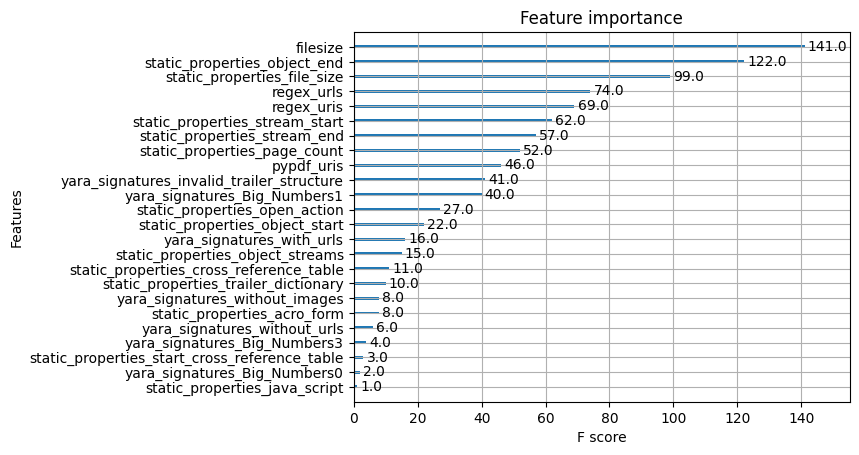

In [116]:
# Plot the contribution of each feature for Base XGB Model

plot_importance(xgb)

## RandomForestClassifier

## Base Model

### Model Training

In [117]:
# Instantiate Model

rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

In [118]:
# Cross - validation

cv_results = cross_val_score(rf_clf, X_train, y_train, cv = skf_cv, scoring = 'accuracy')
print('Cross-validation results:', cv_results)

Cross-validation results: [0.98346667 0.984      0.98293333 0.98453333]


In [119]:
# Model Evaluation using Cross- Validation

mean_acc_cv = cv_results.mean()
cross_val_acc_dict['Base RF'] = mean_acc_cv

print('Mean Accuracy:', mean_acc_cv)

Mean Accuracy: 0.9837333333333333


In [120]:
# Train the base model

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [121]:
# Generate a probability matrix

y_proba_base_rf = rf_clf.predict_proba(X_test)
print(f'Shape of y_proba =  {y_proba_base_rf.shape} \n')
y_proba_base_rf

Shape of y_proba =  (2500, 2) 



array([[0.23351728, 0.76648272],
       [0.84752382, 0.15247618],
       [0.7955868 , 0.2044132 ],
       ...,
       [0.13002236, 0.86997764],
       [0.13002236, 0.86997764],
       [0.49765805, 0.50234195]])

### Model Evaluation

In [122]:
# Calculate FPR, TPR, and thresholds for the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba_base_rf[:, 1])

In [123]:
print(f'Shape = {fpr.shape}, Data Type = {fpr.dtype}')

Shape = (411,), Data Type = float64


In [124]:
print(f'Shape = {tpr.shape}, Data Type = {tpr.dtype}')

Shape = (411,), Data Type = float64


In [125]:
print(f'Shape = {thresholds.shape}, Data Type = {thresholds.dtype}')

Shape = (411,), Data Type = float64


In [126]:
# Since the thresholds[0] represents no instances being predicted and is
# arbitrarily set to max(y_score) + 1.

thresholds = thresholds[thresholds < 1]

In [127]:
# Calculate AUC

auc_base_rf = auc(fpr, tpr)
chosen_auc['Base RF'] = auc_base_rf
auc_base_rf

0.9976527129043493

In [128]:
# Print the Detection Rate of Malicious Files along with coreesponding
# False Positive Rate and Threshold values

print(f'DR vs FP with Thresholds')
for detection_rate, false_positive_rate, thr in zip(tpr, fpr, thresholds):
  print(f'{100 * detection_rate:>6.3f}%', f'{10 * false_positive_rate:10.4f}%', f'{thr:15.4f}')

DR vs FP with Thresholds
 0.000%     0.0000%          0.8726
 0.244%     0.0000%          0.8700
40.717%     0.0000%          0.8659
41.857%     0.0000%          0.8648
46.661%     0.0000%          0.8587
46.906%     0.0000%          0.8586
56.433%     0.0000%          0.8564
58.225%     0.0000%          0.8561
63.355%     0.0000%          0.8545
63.681%     0.0000%          0.8517
63.844%     0.0000%          0.8512
64.007%     0.0000%          0.8509
65.228%     0.0000%          0.8500
65.309%     0.0000%          0.8467
65.717%     0.0000%          0.8434
65.798%     0.0000%          0.8417
65.961%     0.0000%          0.8377
66.205%     0.0000%          0.8373
70.928%     0.0000%          0.8315
71.417%     0.0000%          0.8296
71.580%     0.0000%          0.8279
71.987%     0.0000%          0.8256
72.068%     0.0000%          0.8251
72.068%     0.0079%          0.8248
72.150%     0.0079%          0.8247
72.313%     0.0079%          0.8243
72.394%     0.0079%          0.8229
72.

In [129]:
truncated_roc_vals = [[], [], []]

In [130]:
# Discarding values with FPR > 0.1

truncated_roc_vals_base_rf = truncate_roc(tpr, fpr, thresholds, truncated_roc_vals)

In [131]:
# Calculate Youden J statistic

youden_J = get_youden_J(truncated_roc_vals_base_rf)
len(youden_J)

120

In [132]:
visualize_tpr_fpr_VS_thr(truncated_roc_vals_base_rf, youden_J, 'TPR and FPR for diffrrent Thresolds for XGBoost')

In [133]:
# Pick the model with the highest Detection Rate

highest_detection_rate_base_rf = truncated_roc_vals_base_rf[0][-1]
chosen_tpr['Base RF'] = highest_detection_rate_base_rf
highest_detection_rate_base_rf

0.992671009771987

In [134]:
# Select the corresponding FPR

corresponding_fpr_base_rf = truncated_roc_vals_base_rf[1][-1]
chosen_fpr['Base RF'] = corresponding_fpr_base_rf
corresponding_fpr_base_rf

0.09984276729559749

In [135]:
# Select the corresponding Threshold value

corresponding_threshold_base_rf = truncated_roc_vals_base_rf[2][-1]
chosen_thr['Base RF'] = corresponding_threshold_base_rf
corresponding_threshold_base_rf

0.3552985653185577

In [136]:
visualize_roc_curve(truncated_roc_vals_base_rf, 'ROC Curve for Base Random Forest', auc_base_rf, corresponding_fpr_base_rf, corresponding_threshold_base_rf)

In [137]:
# Predicting Target Class values (Verdict) using probabilities and threshold

# If the variable is less than "corresponding_threshold_base_rf", it will receive a negative prediction.
# Otherwise, it will receive a positive classification.

y_pred_base_rf = (y_proba_base_rf[:, 1] >= corresponding_threshold_base_rf).astype(bool)

In [138]:
print('Shape of y_pred_bare_rf = ', y_pred_base_rf.shape)
pd.Series(y_pred_base_rf).head()

Shape of y_pred_bare_rf =  (2500,)


0     True
1    False
2    False
3    False
4    False
dtype: bool

In [139]:
# Build Confusion Matrix

cf_matrix_base_rf = confusion_matrix(y_test, y_pred_base_rf)      # Index = Actual;  Column = Predicted
cf_matrix_base_rf

array([[1142,  130],
       [   9, 1219]])

In [140]:
rf_labels = np.where(rf_clf.classes_ == 0, False, True)
rf_labels

array([False,  True])

In [141]:
# Plot Confusion Matrix

plot_confusion_matrix(cf_matrix_base_rf, 'Confusion Matrix for Base Random Forest Model', rf_labels)

In [142]:
accuracy_base_rf = accuracy_score(y_test, y_pred_base_rf)
chosen_acc['Base RF'] = accuracy_base_rf
accuracy_base_rf

0.9444

In [143]:
# Display the Classification Report on the model's performance

print(classification_report(y_test, y_pred_base_rf, digits = 5))

              precision    recall  f1-score   support

       False    0.99218   0.89780   0.94263      1272
        True    0.90363   0.99267   0.94606      1228

    accuracy                        0.94440      2500
   macro avg    0.94791   0.94523   0.94435      2500
weighted avg    0.94869   0.94440   0.94432      2500



In [144]:
# Evaluating the Maximum Detection Rate of the Selected Model

max_detection_rate_abse_rf = recall_score(y_test, y_pred_base_rf, pos_label = 1)
max_detection_rate_abse_rf

0.992671009771987

### Feature Importance

In [145]:
# Get feature importances

feature_importances = rf_clf.feature_importances_

In [146]:
# Get the indices of features sorted by importance

indices = feature_importances.argsort()

In [147]:
# Create horizontal bar plot

fig = go.Figure()

fig.add_trace(go.Bar(
    x = feature_importances,
    y = X_train.columns.values,
    orientation = 'h',
    marker = dict(color = 'skyblue'),  # Customize the bar color
))

# Customize layout
fig.update_layout(
    title = "Random Forest Feature Importance",
    xaxis_title = "Feature Importance",
    yaxis_title = "Features",
    height = 500,  # Adjust the height as needed
    width = 800,   # Adjust the width as needed
)

# Show the plot
fig.show()

## Collating the Performnace Metrics of Different Models

In [ ]:
cross_val_acc_dict = {}

chosen_tpr = {}
chosen_fpr = {}
chosen_thr = {}

chosen_auc = {}
chosen_acc = {}

In [150]:
cross_val_series = pd.Series(cross_val_acc_dict, name = 'Cross Vlidation Accuracy')
cross_val_series

Base ETSC   0.996800
Base XGB    0.995733
Base RF     0.983733
Name: Cross Vlidation Accuracy, dtype: float64

In [151]:
chosen_tpr_series = pd.Series(chosen_tpr, name = 'Detection Rate')
chosen_tpr_series

Base ETSC   0.996743
Base XGB    0.997557
Base RF     0.992671
Name: Detection Rate, dtype: float64

In [153]:
chosen_fpr_series = pd.Series(chosen_fpr, name = 'False Positive Rate')
chosen_fpr_series

Base ETSC   0.073113
Base XGB    0.099843
Base RF     0.099843
Name: False Positive Rate, dtype: float64

In [155]:
chosen_auc_series = pd.Series(chosen_auc, name = 'Area Under Curve(AUC)')
chosen_auc_series

Base ETSC   0.998803
Base XGB    0.999362
Base RF     0.997653
Name: Area Under Curve(AUC), dtype: float64

In [156]:
chosen_acc_series = pd.Series(chosen_acc, name = 'Accuracy')
chosen_acc_series

Base ETSC   0.908400
Base XGB    0.947200
Base RF     0.944400
Name: Accuracy, dtype: float64

In [157]:
performance_df = pd.concat([chosen_tpr_series, chosen_fpr_series, chosen_auc_series, chosen_acc_series], axis=1)
performance_df

,Detection Rate,False Positive Rate,Area Under Curve(AUC),Accuracy
Base ETSC,0.996743,0.073113,0.998803,0.908400
Base XGB,0.997557,0.099843,0.999362,0.947200
Base RF,0.992671,0.099843,0.997653,0.944400
